# Machine_Learning_Texts_S14
### Movie Reveiws Detection Models

# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

# Sklearn imports
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# NLP libraries
import nltk
from nltk.corpus import stopwords
import spacy

# Transformers and deep learning
import torch
import transformers

# LightGBM
from lightgbm import LGBMClassifier

In [2]:
# plots are displayed directly within the notebook as inline images
%matplotlib inline

#configures the format of the graphs to use the PNG (Portable Network Graphics) format.
%config InlineBackend.figure_format = 'png'

# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

# applies the Seaborn style to matplotlib plots
plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
display((df_reviews['end_year']== '\\N').sum())

45052

In [7]:
display(df_reviews.head())

tconst title_type primary_title original_title  start_year end_year  \
0  tt0068152      movie             $              $        1971       \N   
1  tt0068152      movie             $              $        1971       \N   
2  tt0313150      short          '15'           '15'        2002       \N   
3  tt0313150      short          '15'           '15'        2002       \N   
4  tt0313150      short          '15'           '15'        2002       \N   

  runtime_minutes  is_adult              genres  average_rating  votes  \
0             121         0  Comedy,Crime,Drama             6.3   2218   
1             121         0  Comedy,Crime,Drama             6.3   2218   
2              25         0  Comedy,Drama,Short             6.3    184   
3              25         0  Comedy,Drama,Short             6.3    184   
4              25         0  Comedy,Drama,Short             6.3    184   

                                              review  rating   sp  pos  \
0  The pakage implies that Warren Beatty and Gold...       1  neg    0   
1  How the hell did they get this made?! Presenti...       1  neg    0   
2  There is no real story the film seems more lik...       3  neg    0   
3  Um .... a serious film about troubled teens in...       7  pos    1   
4  I'm totally agree with GarryJohal from Singapo...       9  pos    1   

  ds_part   idx  
0   train  8335  
1   train  8336  
2    test  2489  
3    test  9280  
4    test  9281

In [8]:
df_reviews.describe()

start_year      is_adult  average_rating         votes        rating  \
count  47331.000000  47331.000000    47329.000000  4.732900e+04  47331.000000   
mean    1989.631235      0.001732        5.998278  2.556292e+04      5.484608   
std       19.600364      0.041587        1.494289  8.367004e+04      3.473109   
min     1894.000000      0.000000        1.400000  9.000000e+00      1.000000   
25%     1982.000000      0.000000        5.100000  8.270000e+02      2.000000   
50%     1998.000000      0.000000        6.300000  3.197000e+03      4.000000   
75%     2004.000000      0.000000        7.100000  1.397400e+04      9.000000   
max     2010.000000      1.000000        9.700000  1.739448e+06     10.000000   

                pos           idx  
count  47331.000000  47331.000000  
mean       0.498954   6279.697999  
std        0.500004   3605.702545  
min        0.000000      0.000000  
25%        0.000000   3162.000000  
50%        0.000000   6299.000000  
75%        1.000000   9412.000000  
max        1.000000  12499.000000

In [9]:
# Extract the 'start_year' column
start_year = df_reviews['start_year']

# Calculate Q1 and Q3
Q1 = start_year.quantile(0.25)
Q3 = start_year.quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Determine outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = start_year[(start_year < lower_bound) | (start_year > upper_bound)]

# Summary
print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
print(f"Number of outliers: {len(outliers)}")

Q1: 1982.0, Q3: 2004.0, IQR: 22.0
Lower bound: 1949.0, Upper bound: 2037.0
Number of outliers: 3146


In [10]:
df_reviews.duplicated().sum()

0

In [11]:
df_reviews.duplicated(subset=['review', 'pos', 'ds_part']).sum()
df_reviews = df_reviews.drop_duplicates(subset=['review', 'pos', 'ds_part'])

In [12]:
# Display rows with any NaN values
rows_with_na = df_reviews[df_reviews.isna().any(axis=1)]

# Display the result
display(rows_with_na)

tconst title_type      primary_title     original_title  start_year  \
22280  tt0192317      movie  Mila Ass Painting  Mila Ass Painting        1998   
22281  tt0192317      movie  Mila Ass Painting  Mila Ass Painting        1998   

      end_year runtime_minutes  is_adult genres  average_rating  votes  \
22280       \N              \N         0     \N             NaN   <NA>   
22281       \N              \N         0     \N             NaN   <NA>   

                                                  review  rating   sp  pos  \
22280  This is a truly great film, with excellent dir...       9  pos    1   
22281  A film is beyond all expectations, an excellen...      10  pos    1   

      ds_part   idx  
22280    test  3231  
22281    test  3232

In [13]:
# Replace all occurrences of '\N' with NaN
df_reviews.replace('\\N', np.nan, inplace=True)

# Replace all occurrences of '\N' with NaN
df_reviews.replace('<NA>', np.nan, inplace=True)

#seeing how many NaN values there are now
display(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47241 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47241 non-null  object 
 1   title_type       47241 non-null  object 
 2   primary_title    47241 non-null  object 
 3   original_title   47241 non-null  object 
 4   start_year       47241 non-null  int64  
 5   end_year         2273 non-null   object 
 6   runtime_minutes  46753 non-null  object 
 7   is_adult         47241 non-null  int64  
 8   genres           47215 non-null  object 
 9   average_rating   47239 non-null  float64
 10  votes            47239 non-null  Int64  
 11  review           47241 non-null  object 
 12  rating           47241 non-null  int64  
 13  sp               47241 non-null  object 
 14  pos              47241 non-null  int64  
 15  ds_part          47241 non-null  object 
 16  idx              47241 non-null  int64  
dtypes: Int64(1),

None

In [14]:
# Drop the 'end_year' column
df_reviews = df_reviews.drop(columns=['end_year'])

In [15]:
# Drop all rows with NaN values
df_reviews.dropna(inplace=True)

#seeing df info()
display(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46737 entries, 0 to 47330
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           46737 non-null  object 
 1   title_type       46737 non-null  object 
 2   primary_title    46737 non-null  object 
 3   original_title   46737 non-null  object 
 4   start_year       46737 non-null  int64  
 5   runtime_minutes  46737 non-null  object 
 6   is_adult         46737 non-null  int64  
 7   genres           46737 non-null  object 
 8   average_rating   46737 non-null  float64
 9   votes            46737 non-null  Int64  
 10  review           46737 non-null  object 
 11  rating           46737 non-null  int64  
 12  sp               46737 non-null  object 
 13  pos              46737 non-null  int64  
 14  ds_part          46737 non-null  object 
 15  idx              46737 non-null  int64  
dtypes: Int64(1), float64(1), int64(5), object(9)
memory usage:

None

### Initial Take Away:
 
- 2 rows in 'average_rating' and 'votes' columns are missing values. These will be taken out of the data
- 'rating' is out of 10
- Overall there is about a 50% positive rating
- IQR the 'start_year' and 3000 movies are outliers. Keeping this data for now since its ~6% of the data
- 'end_year' is '/N' for 45,000 / 47,331 making this column meaningless and will be dropped
- No fully duplicated lines
- occurences of NaN values that have different strings. replacing all with NaN
- dropping all occurences of NaN


## EDA

Let's check the number of movies and reviews over years.

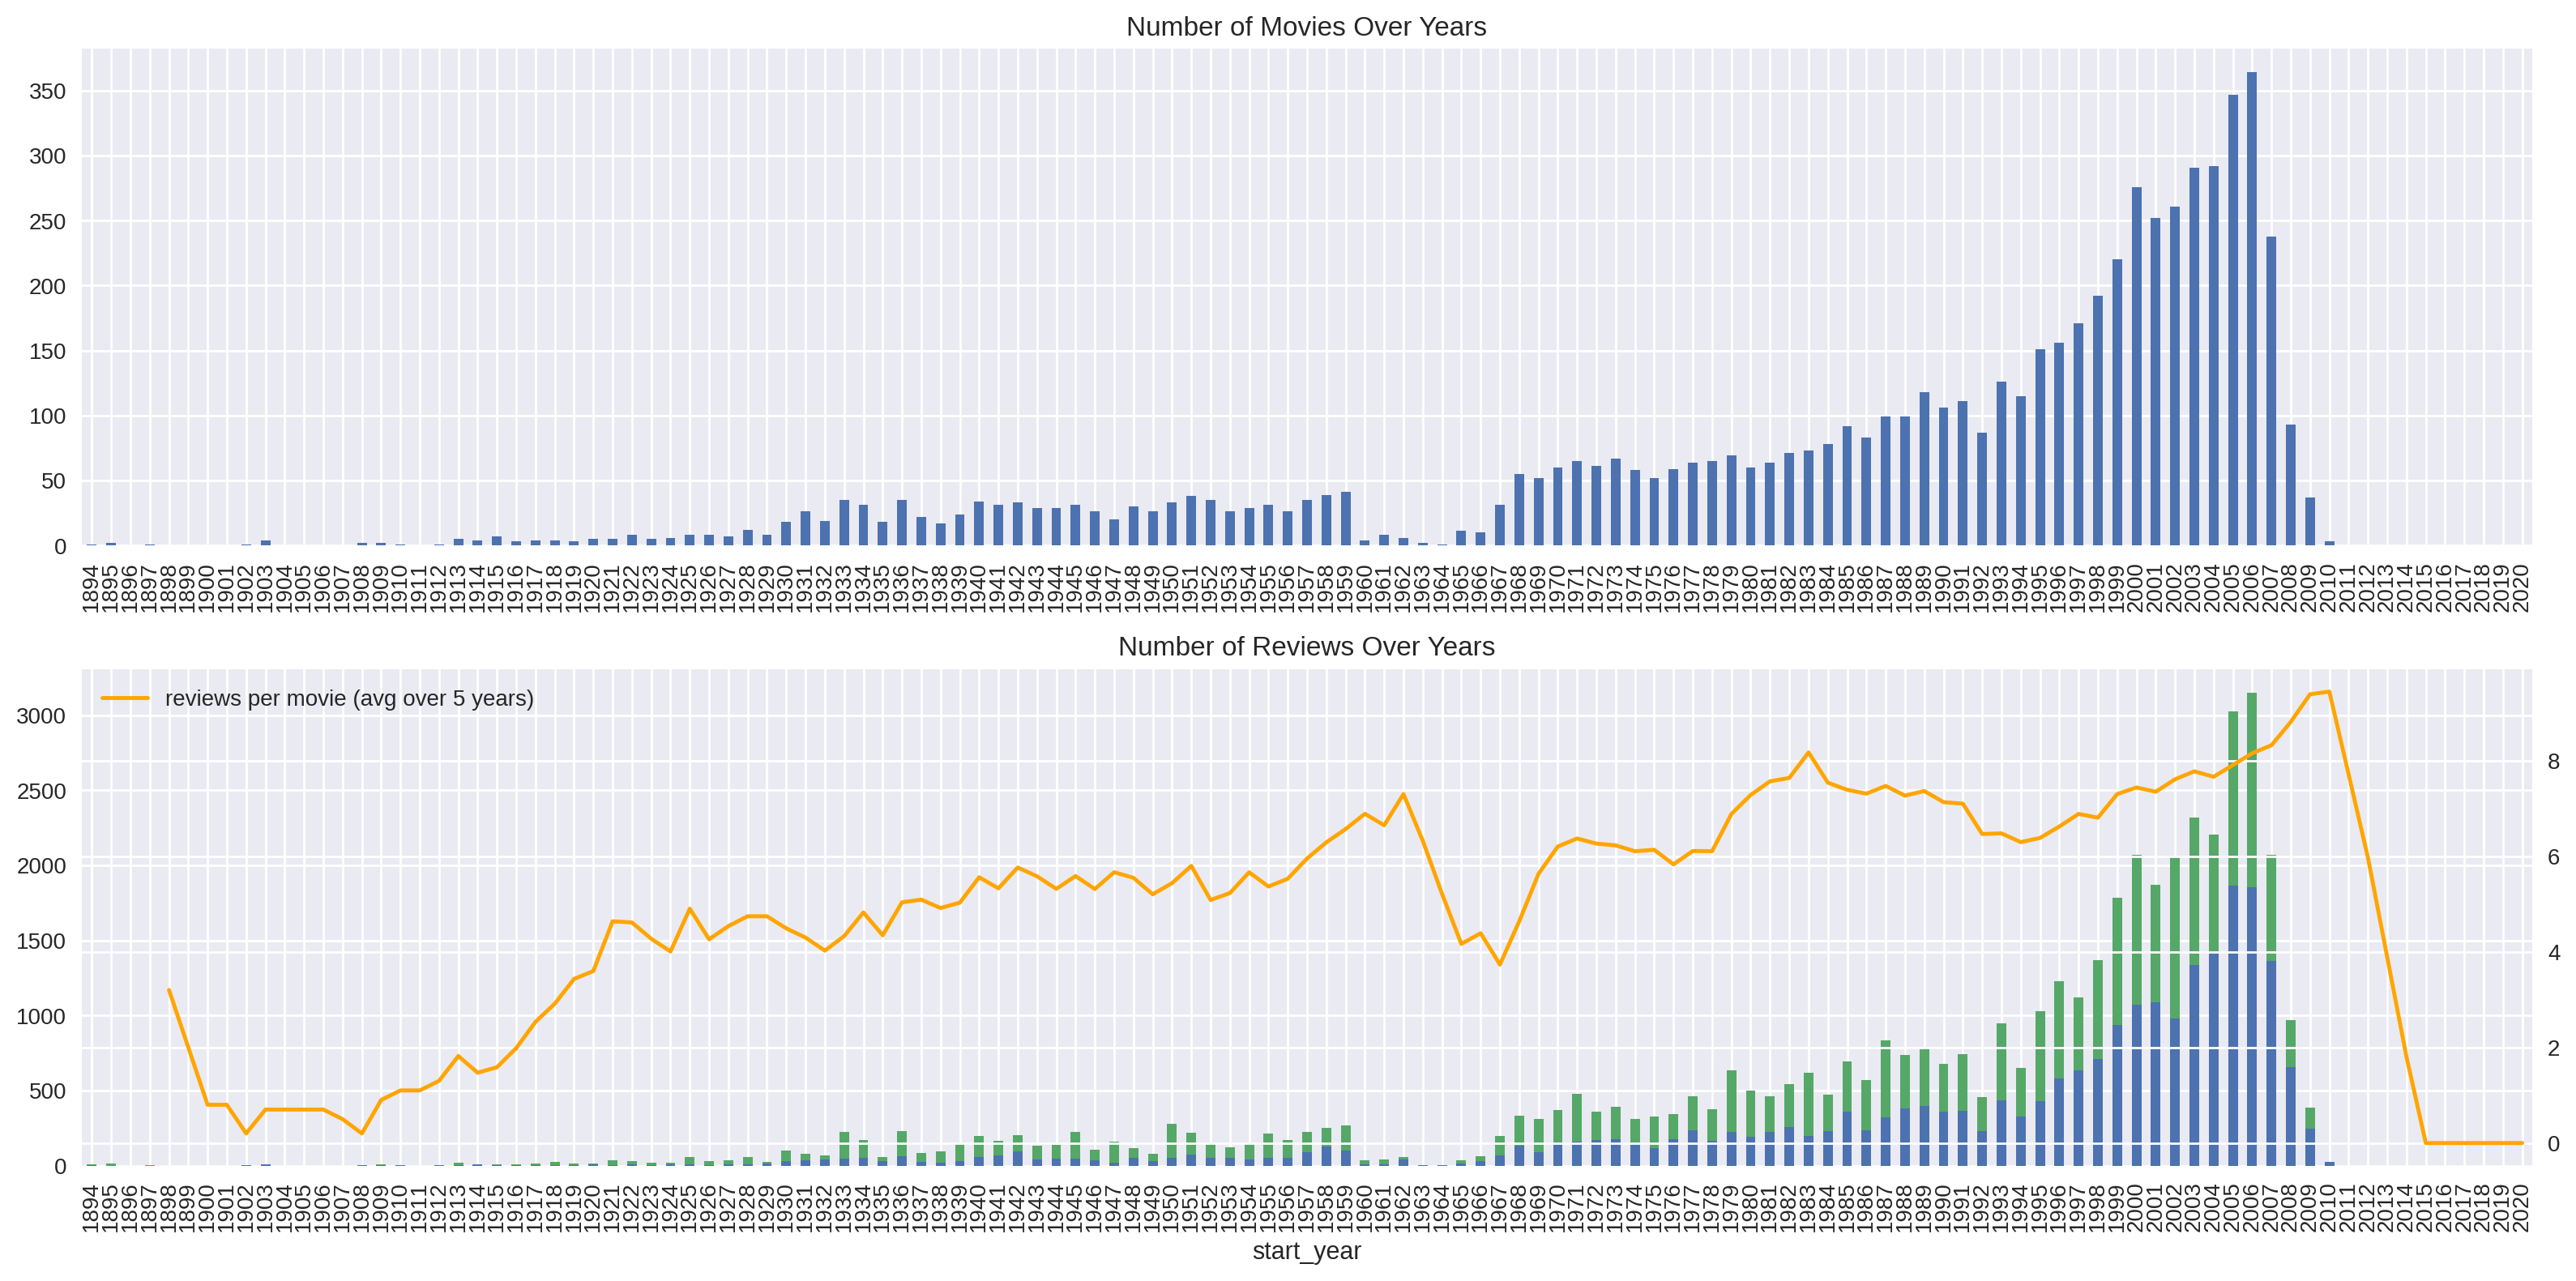

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

***Take Aways:***
- the number of movies is increasing skewing the data to the left
- the number of reviews slightly increases

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

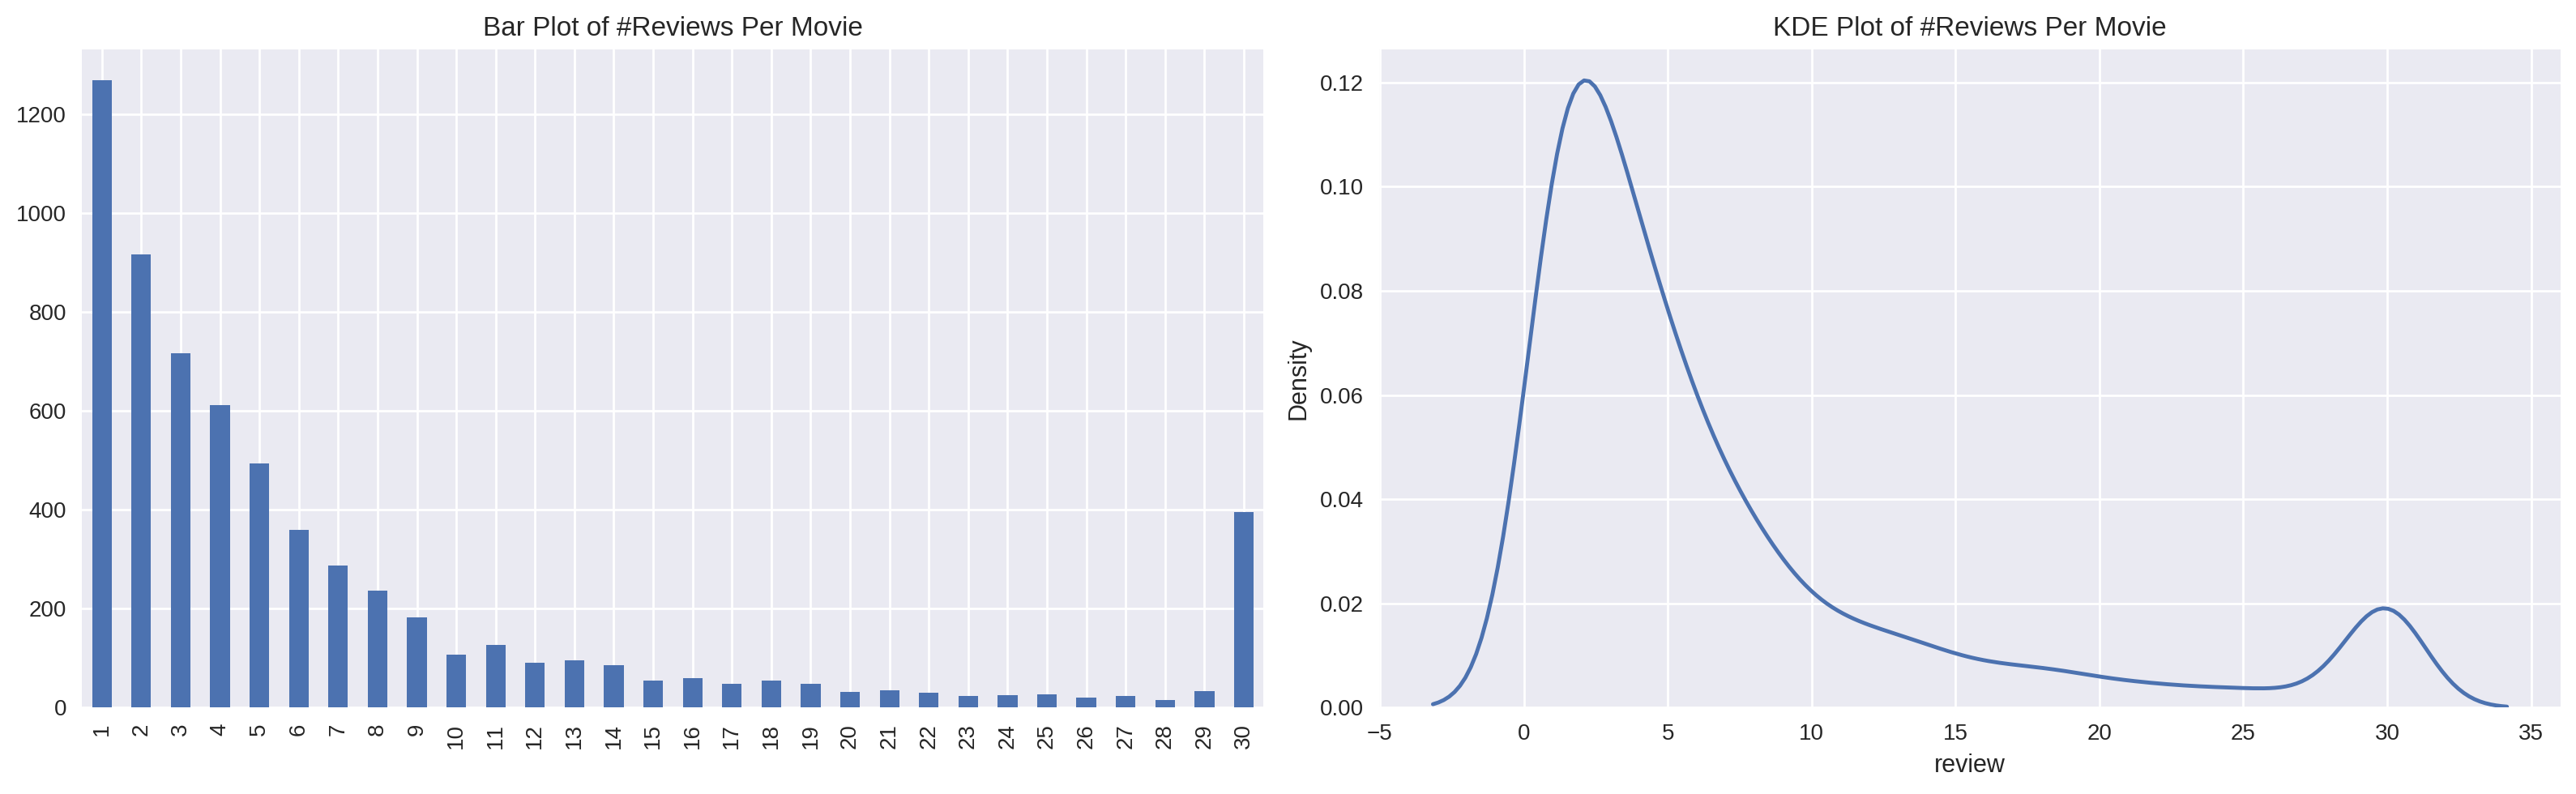

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

***Take Aways:***
- The number of reviews per movie is right skewed with many movies with only a few reviews
- one spike at 30 reviews per movie but overall low amounts of reviews per movie


In [18]:
df_reviews['pos'].value_counts()

0    23474
1    23263
Name: pos, dtype: int64

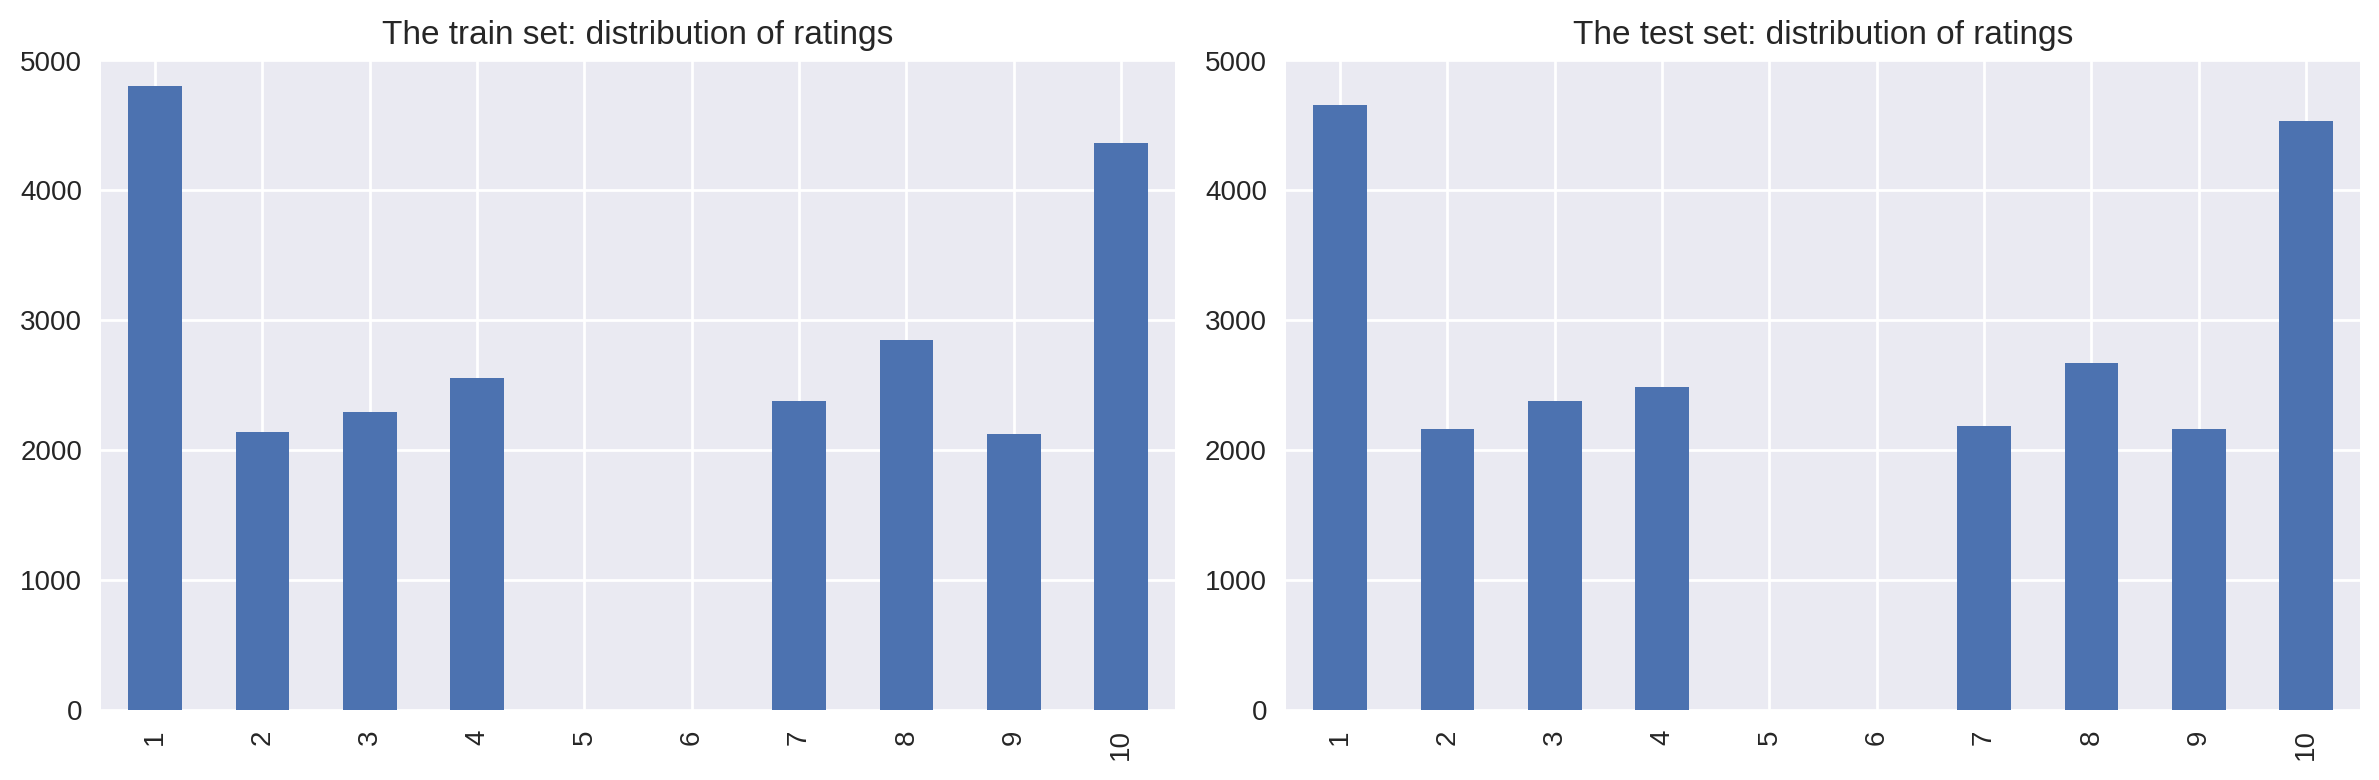

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

***Take Aways:***
- The training and test set look like they have pretty equal distributions of ratings which will be good for the accuracy of the predictions


Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


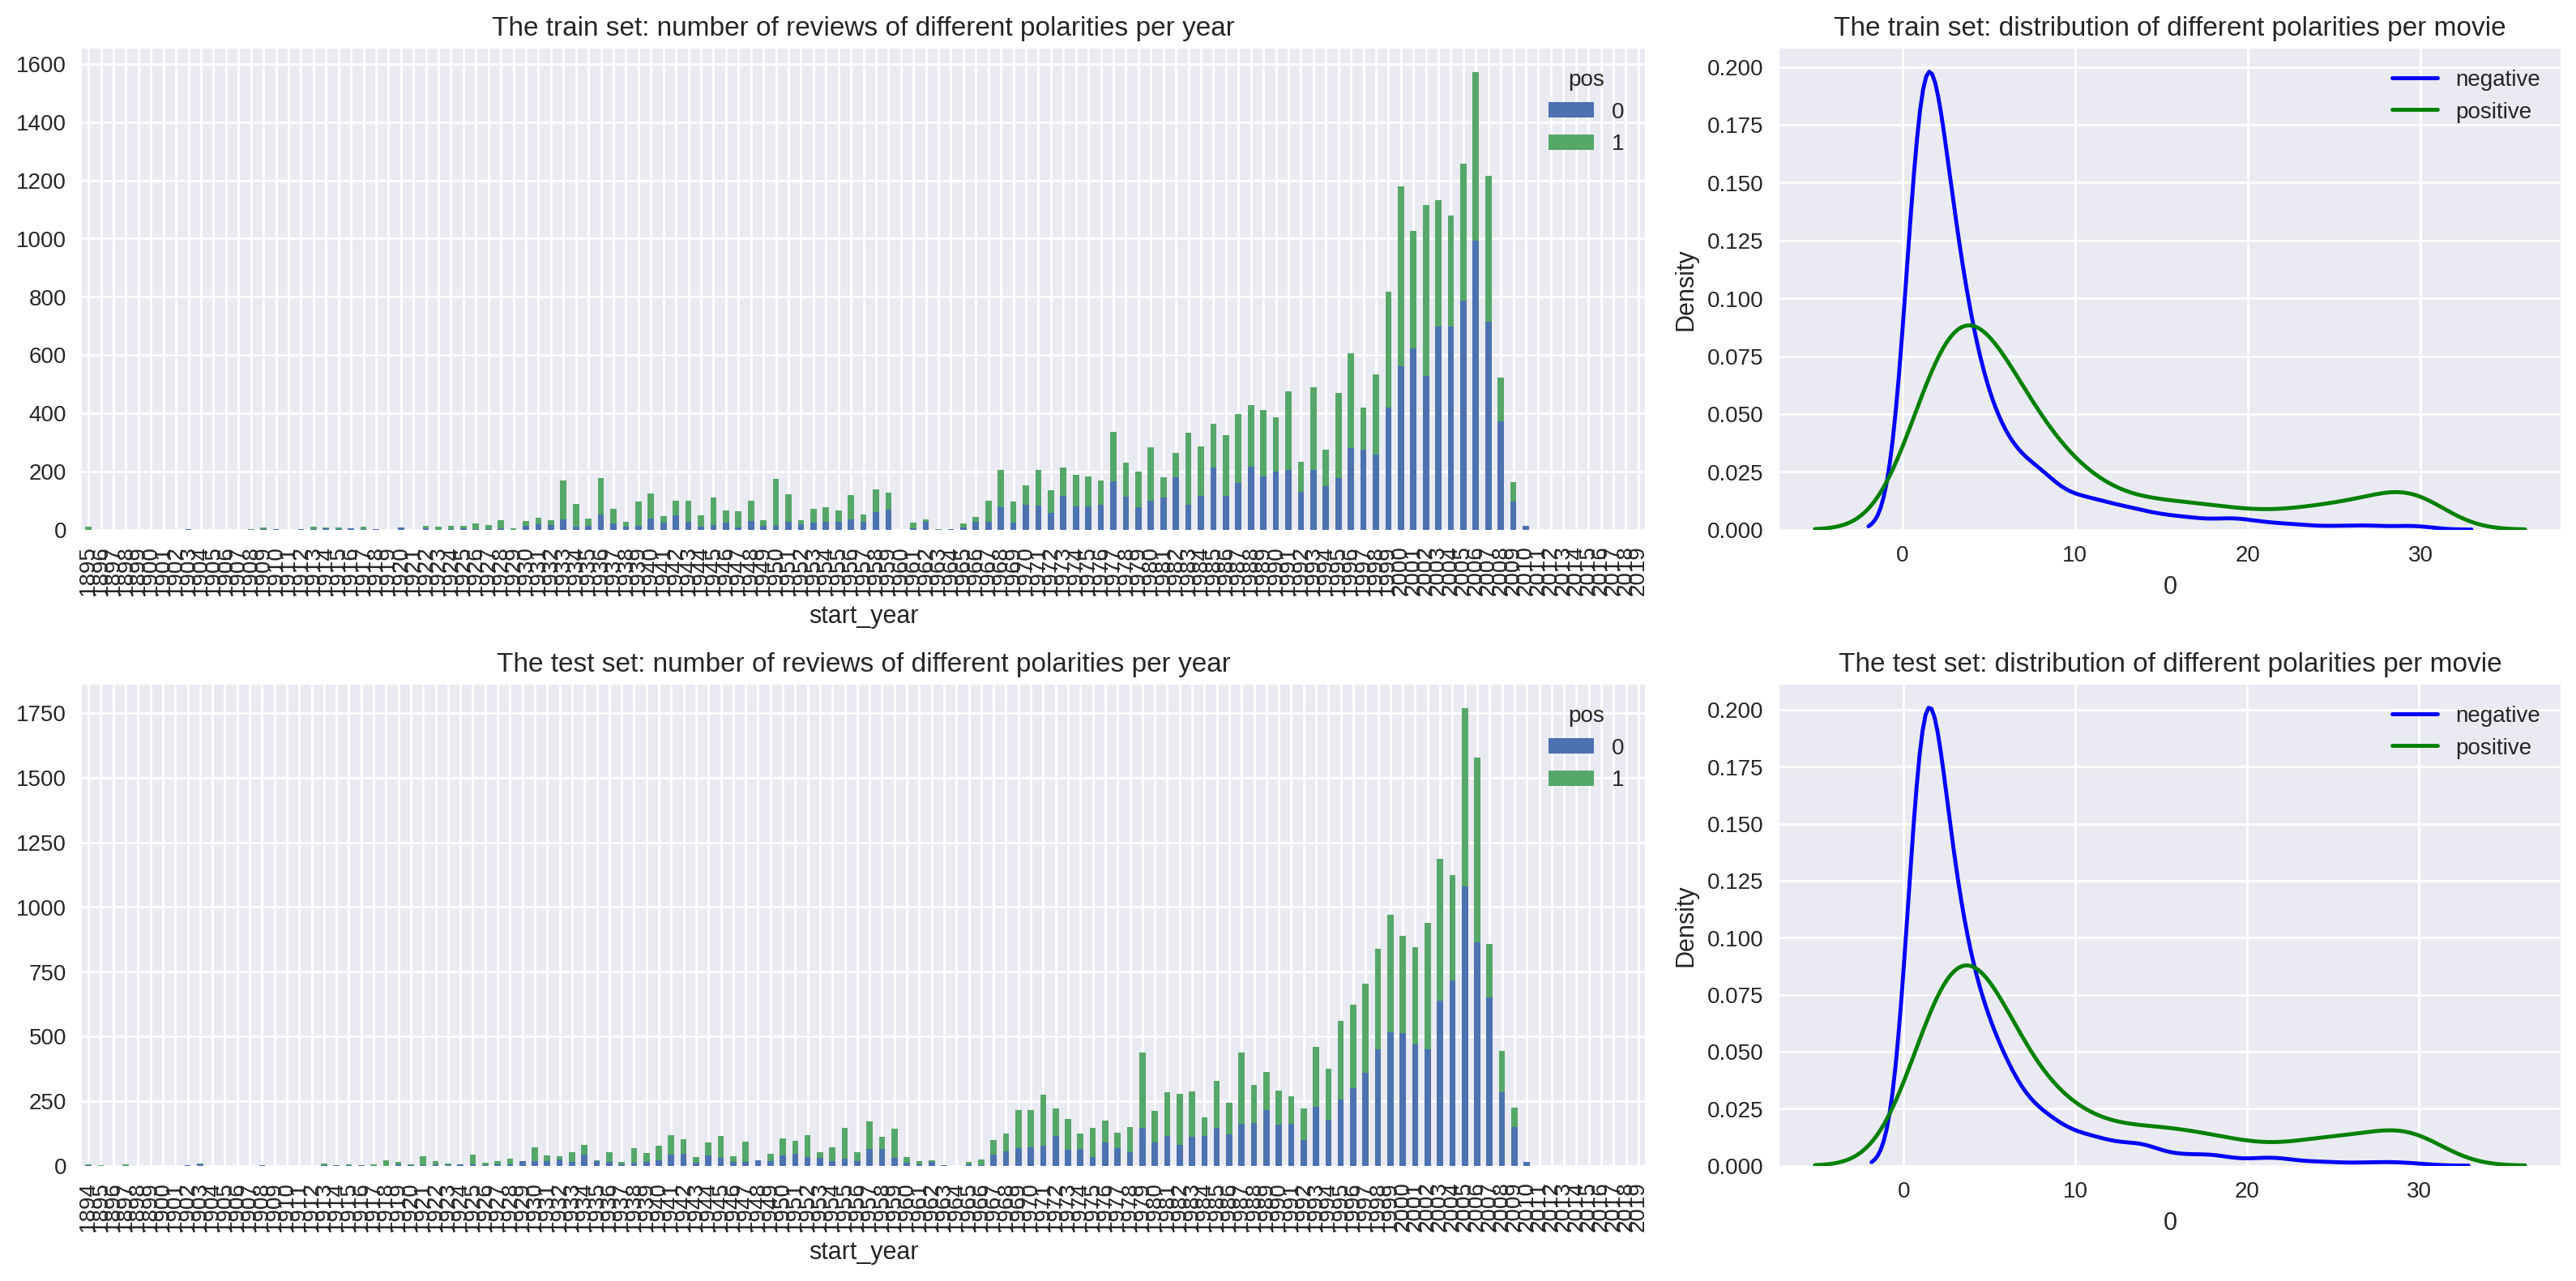

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

***Take Aways:***
- The training and test set look like they have pretty equal distributions of negative to positive ratings which will be good for the accuracy of the predictions

### Class Imbalance
- The distribution of Positive to negative reviews is very balanced at ~50%
- There is a slight inbalance to the number of older movies to the more numerous newer movies, but won't effect the project
- Most movies have a few reviews with a small amount having a lot of reviews, nothing will be done now but this could effect the project and will be kept in mind if the predictions aren't accurate


## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [21]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for data_type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[data_type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = roc_curve(target, pred_proba)
        roc_auc = roc_auc_score(target, pred_proba)    
        eval_stats[data_type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = precision_recall_curve(target, pred_proba)
        aps = average_precision_score(target, pred_proba)
        eval_stats[data_type]['APS'] = aps
        
        if data_type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{data_type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{data_type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{data_type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[data_type]['Accuracy'] = accuracy_score(target, pred_target)
        eval_stats[data_type]['F1'] = f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [22]:
# Function to normalize text
def normalize_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove digits and punctuation using regex
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d', '', text)       # Remove digits
    return text

# Apply the normalization function to the review column
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [23]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23505, 17)
(23232, 17)


## Working with models

### Model 0 - Constant

In [24]:
# Assigning reveiw norm and pos
X_train = df_reviews_train['review_norm']
y_train = df_reviews_train['pos']

X_test = df_reviews_test['review_norm']
y_test = df_reviews_test['pos']

# Initialize the DummyClassifier with 'most_frequent' strategy
model = DummyClassifier(strategy='most_frequent')

# Fit the model
model.fit(X_train.values.reshape(-1, 1), y_train)

# Make predictions
y_pred = model.predict(X_test.values.reshape(-1, 1))

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of DummyClassifier (Constant model): {accuracy:.4f}")

Accuracy of DummyClassifier (Constant model): 0.5029


### Take Aways:

- The constant model(DummyClassifier) reports an accuracy of 50% as the baseline to compare to the other trained models below. In essence the models are being compared to a coin toss and should be better than this DummyClassifier model.

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [25]:
# Prepare the stopwords list for text preprocessing
stop_words = stopwords.words('english')

# Initialize spaCy model (only once)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

# Sample train and test features
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
def preprocess_and_vectorize_text(df_train, df_test, method='tfidf', max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    """
    Preprocess and vectorize text data using the specified method.

    Arguments:
    - df_train: Training DataFrame
    - df_test: Testing DataFrame
    - method: Vectorization method ('tfidf', 'spacy', or 'bert')
    - max_length: Maximum length for BERT tokenization (default 512)
    - batch_size: Batch size for BERT embedding generation (default 100)
    - force_device: Force device for BERT ('cuda' or 'cpu')
    - disable_progress_bar: Disable progress bar for batch processing

    Returns:
    - train_features: Preprocessed and vectorized training features
    - test_features: Preprocessed and vectorized testing features
    """
    # Define text preprocessing steps for spaCy
    def spacy_preprocess(text):
        doc = nlp(text)
        tokens = [token.lemma_ for token in doc]
        return ' '.join(tokens)

    # Preprocessing step (common for all methods)
    if method == 'spacy':
        df_train['review_norm'] = df_train['review'].apply(spacy_preprocess)
        df_test['review_norm'] = df_test['review'].apply(spacy_preprocess)
        vectorizer = TfidfVectorizer()

    elif method == 'tfidf':
        vectorizer = TfidfVectorizer(stop_words='english')
        df_train['review_norm'] = df_train['review']
        df_test['review_norm'] = df_test['review']

        # Vectorizing using TF-IDF
        train_features = vectorizer.fit_transform(df_train['review_norm'])
        test_features = vectorizer.transform(df_test['review_norm'])
        return train_features, test_features

    else:
        raise ValueError("Invalid method. Choose from 'tfidf', 'spacy', or 'bert'.")

    # Vectorizing using spaCy embeddings
    train_features = vectorizer.fit_transform(df_train['review_norm'])
    test_features = vectorizer.transform(df_test['review_norm'])
    return train_features, test_features


In [27]:
%%time

# Preprocess and vectorize text data for Model 1 (TF-IDF in this case)
method = 'tfidf'  # Or 'spacy' or 'bert'
train_features_1, test_features_1 = preprocess_and_vectorize_text(df_reviews_train, df_reviews_test, method=method)

# Check the shape of the transformed features
print(f"Train Features Shape: {train_features_1.shape}")
print(f"Test Features Shape: {test_features_1.shape}")

# Model 1 (Logistic Regression example)
model_1 = LogisticRegression(max_iter=1000, random_state=42)
model_1.fit(train_features_1, train_target)

Train Features Shape: (23505, 72459)
Test Features Shape: (23232, 72459)
CPU times: user 5.99 s, sys: 3.71 s, total: 9.7 s
Wall time: 9.68 s


LogisticRegression(max_iter=1000, random_state=42)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95
CPU times: user 324 ms, sys: 42.1 ms, total: 366 ms
Wall time: 425 ms


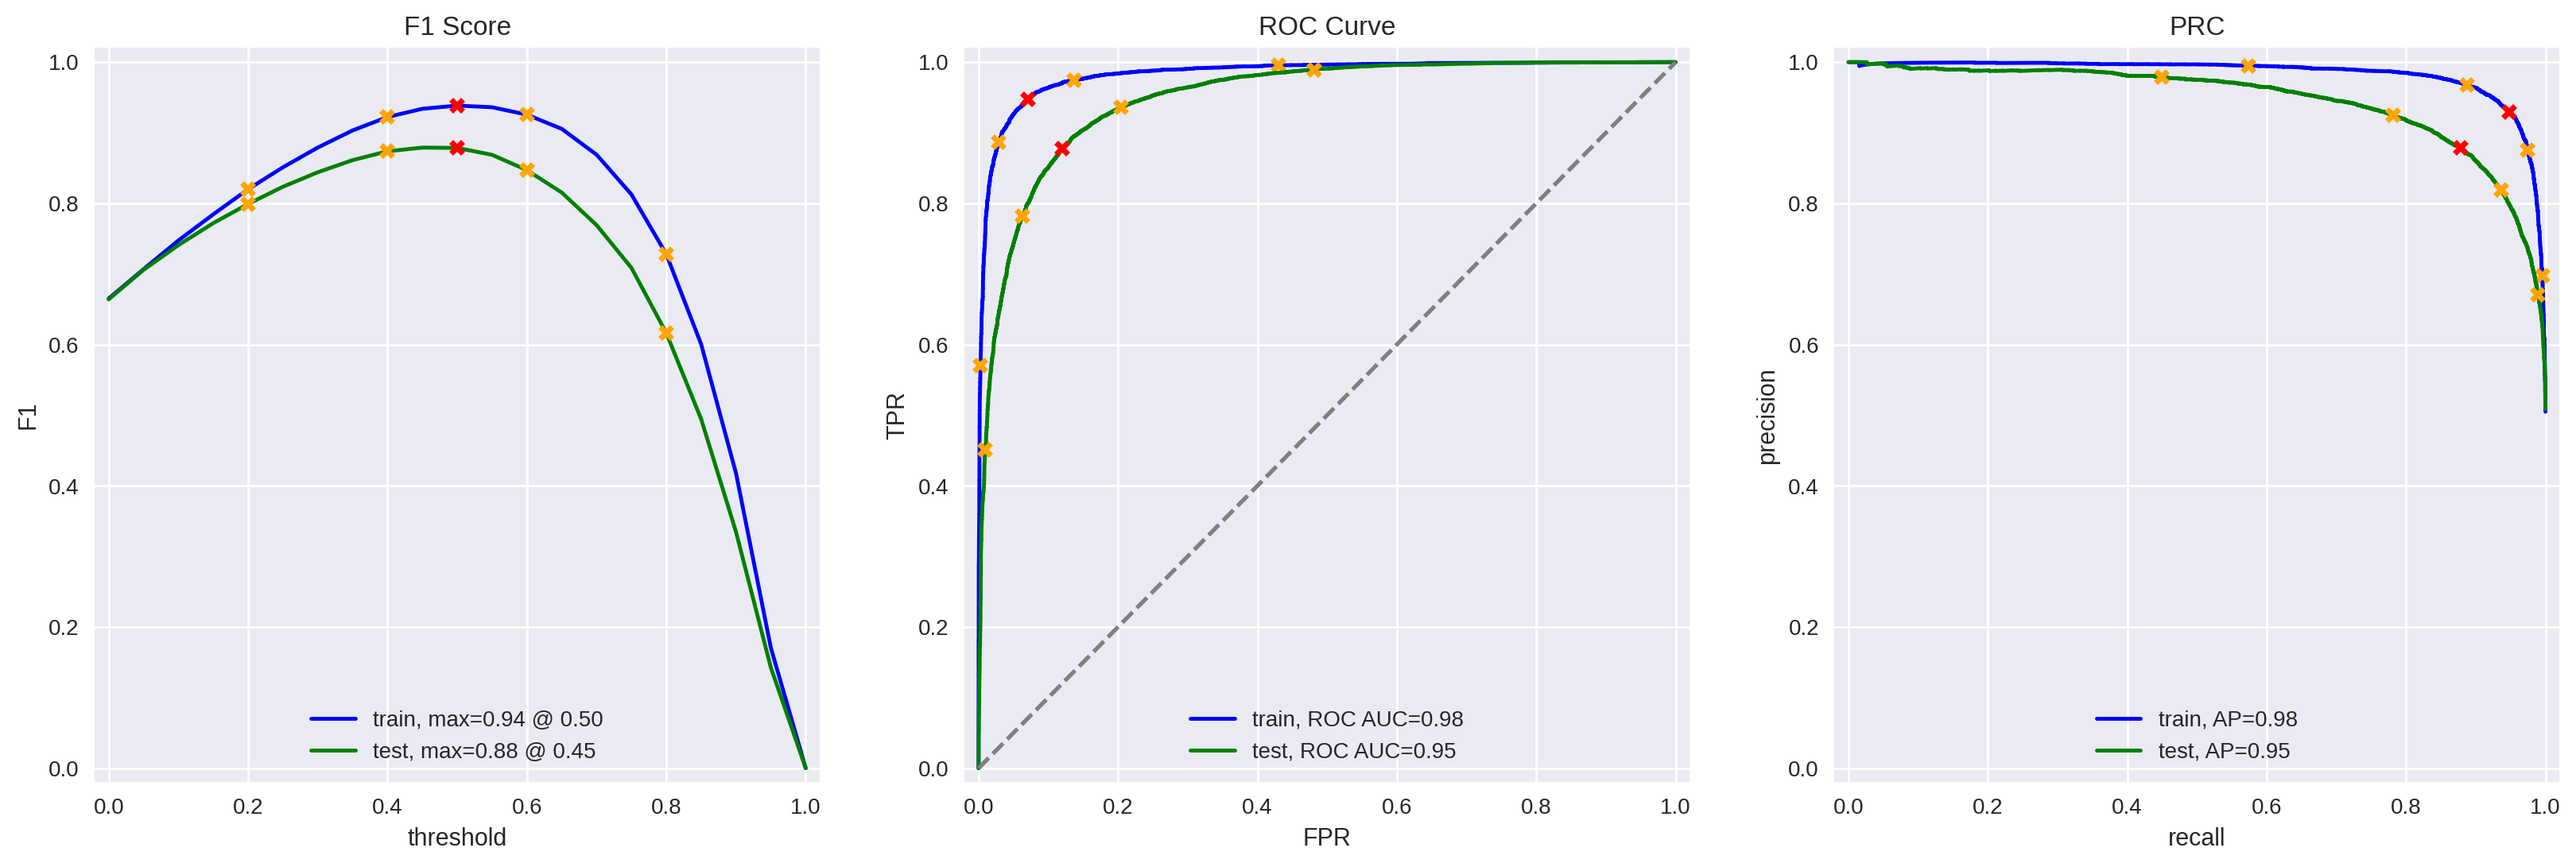

In [28]:
%%time

# Evaluate the model
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Take Aways:

The results indicate that the model performs well on both the training and test datasets, with high accuracy (0.94 train, 0.88 test) and F1 scores (0.94 train, 0.88 test). Additionally, the APS (average precision score) and ROC AUC values demonstrate strong predictive power (APS: 0.98 train, 0.95 test; ROC AUC: 0.98 train, 0.95 test), suggesting the model generalizes effectively without significant overfitting.


### Model 3 - spaCy, TF-IDF and LR

In [29]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [30]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [31]:
%%time

# Apply the preprocessing function to the text columns in both train and test datasets
df_reviews_train['review_lemmatized'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_lemmatized'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(df_reviews_train['review_lemmatized'])

# Transform the test data using the same vectorizer
X_test_tfidf = vectorizer.transform(df_reviews_test['review_lemmatized'])

# Define the target variable for both train and test data
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

# Initialize the Logistic Regression model
model_3 = LogisticRegression(max_iter=1000, random_state=42)

# Train the model on the TF-IDF transformed data
model_3.fit(X_train_tfidf, train_target)

CPU times: user 8min 2s, sys: 3.85 s, total: 8min 6s
Wall time: 8min 8s


LogisticRegression(max_iter=1000, random_state=42)

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95
CPU times: user 310 ms, sys: 31 µs, total: 310 ms
Wall time: 320 ms


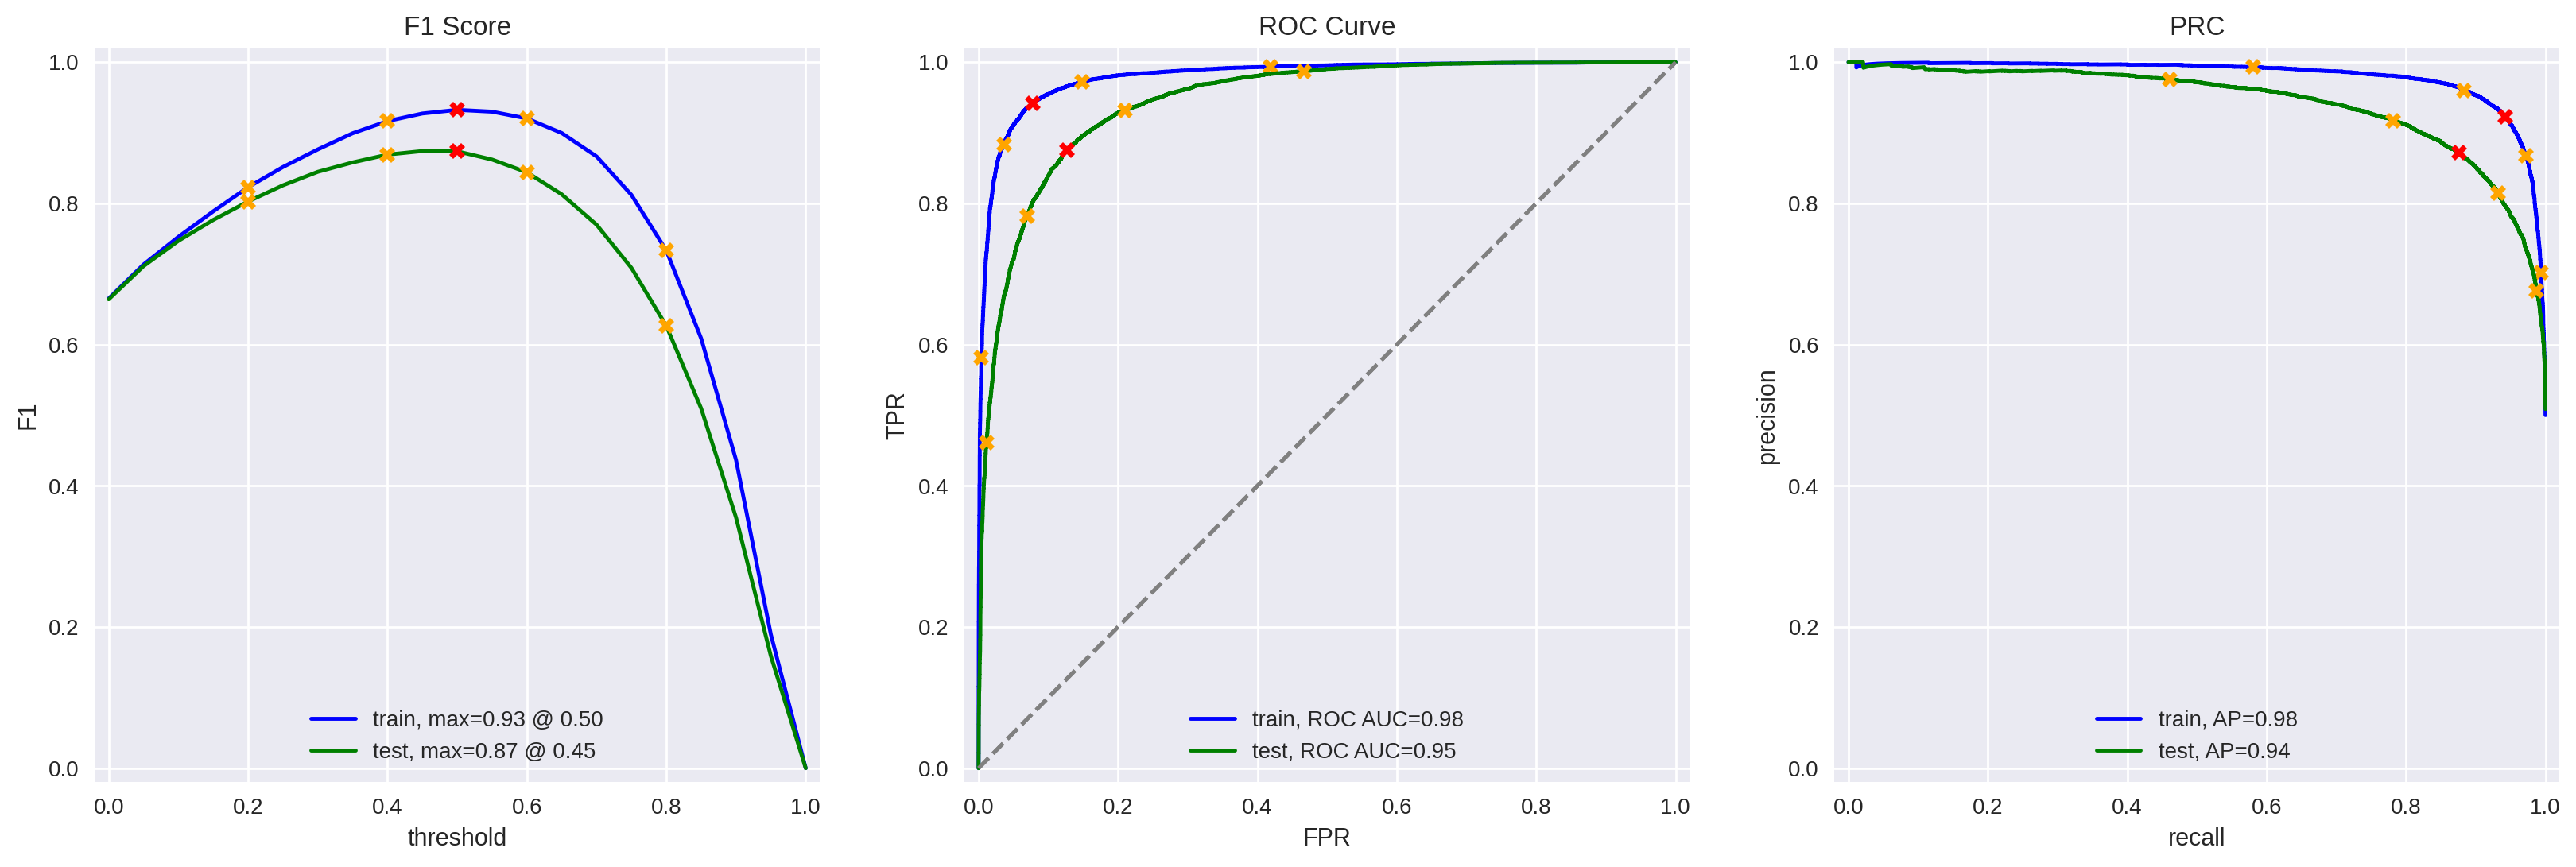

In [32]:
%%time

#evaluate the trained model using the evaluate_model function
evaluate_model(model_3, X_train_tfidf, train_target, X_test_tfidf, test_target)

### Take Aways:

The model demonstrates strong performance, with high accuracy (0.87) and F1 scores (0.87) on the test set, indicating effective classification and balanced precision and recall. The high APS (0.94) and ROC AUC (0.95) suggest excellent ability to rank positive samples and distinguish between classes, confirming that the TF-IDF vectorizer and logistic regression pipeline generalize well to unseen data.


### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [33]:
%%time

# Initialize the LightGBM Classifier model
model_4 = LGBMClassifier(n_estimators=100, learning_rate=0.05, random_state=42)

# Train the model on the TF-IDF transformed data
model_4.fit(X_train_tfidf, train_target)

CPU times: user 27.6 s, sys: 107 ms, total: 27.7 s
Wall time: 27.7 s


LGBMClassifier(learning_rate=0.05, random_state=42)

          train  test
Accuracy   0.87  0.83
F1         0.87  0.83
APS        0.94  0.91
ROC AUC    0.94  0.92
CPU times: user 922 ms, sys: 21 µs, total: 922 ms
Wall time: 959 ms


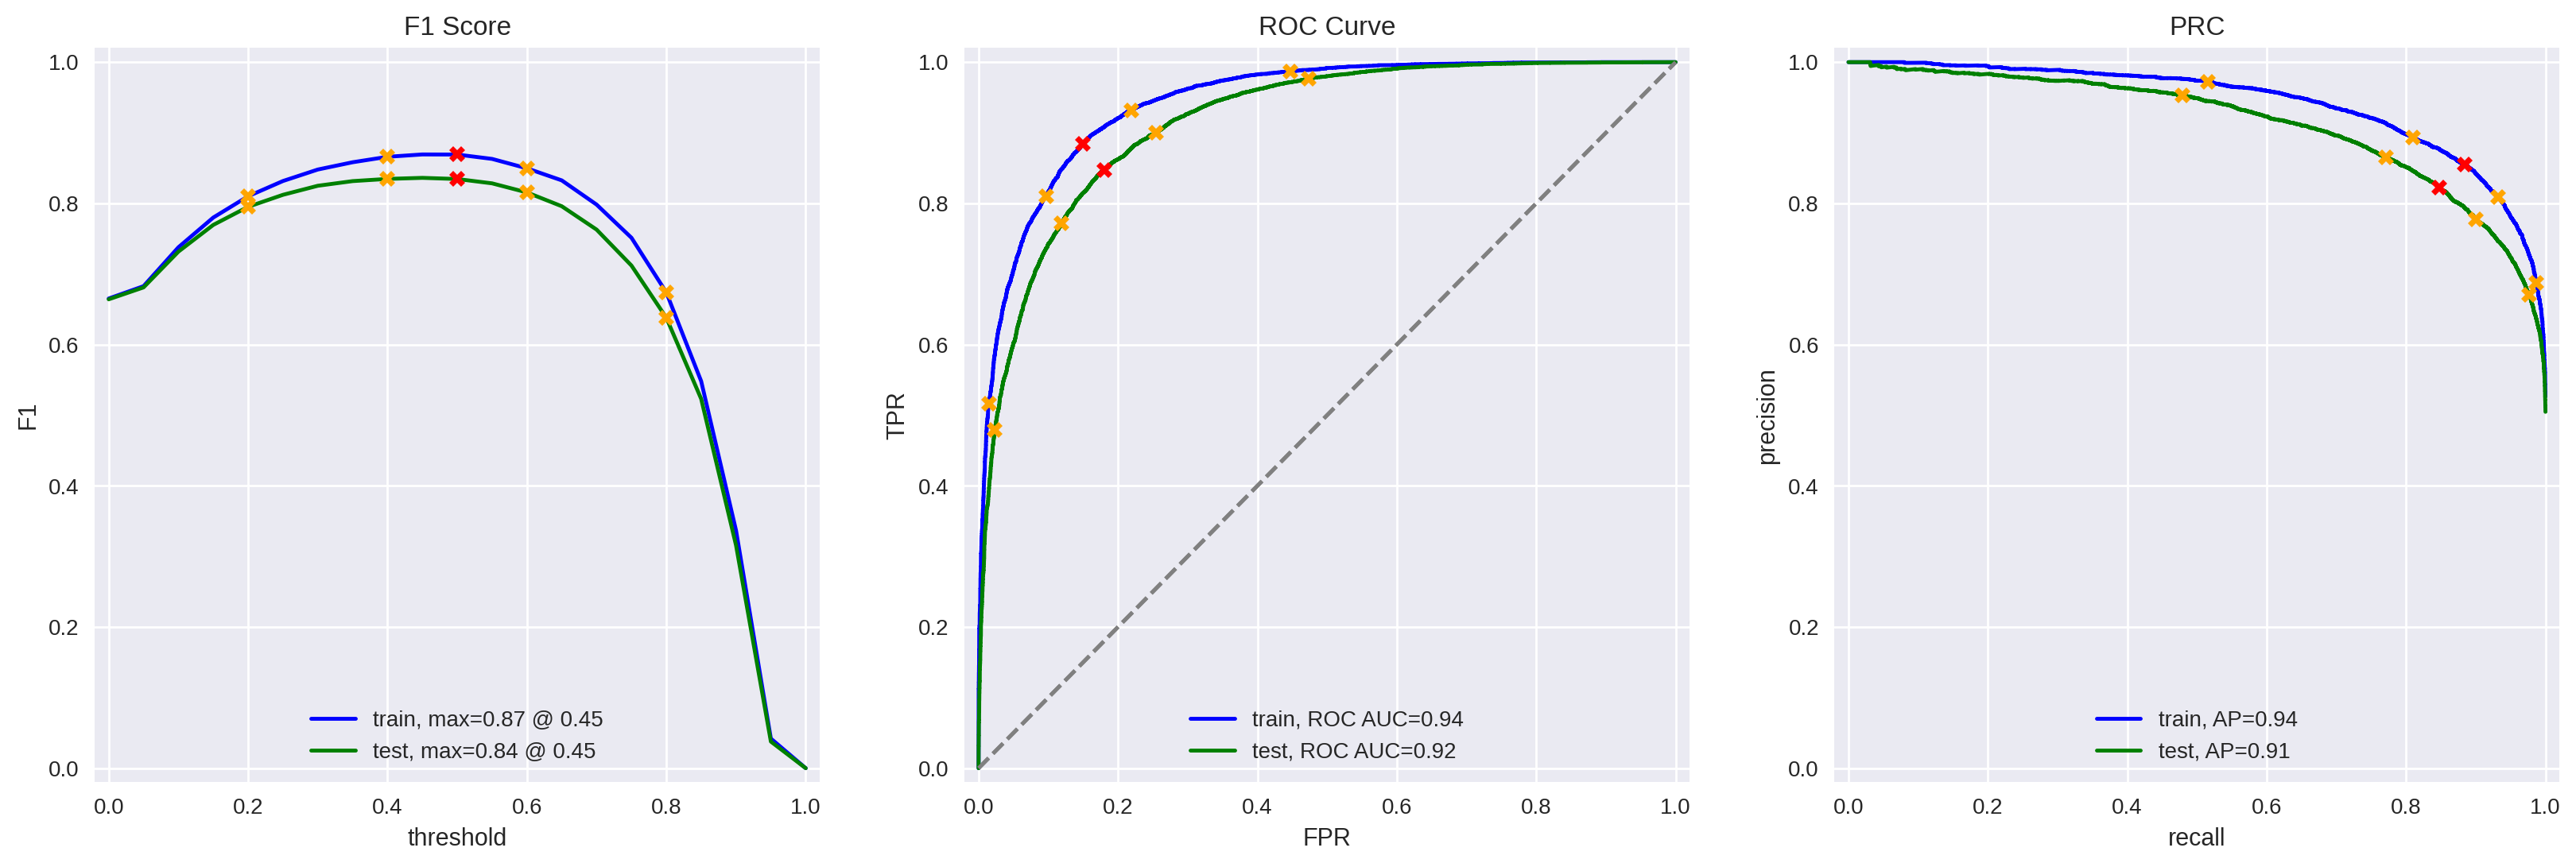

In [34]:
%%time

# Evaluate the model using the evaluate_model function
evaluate_model(model_4, X_train_tfidf, train_target, X_test_tfidf, test_target)

### Take Aways:

The LightGBM model shows solid performance, achieving an accuracy and F1 score of 0.83 on the test set, reflecting consistent and balanced classification. The APS (0.91) and ROC AUC (0.92) indicate strong ranking and class-separation capabilities. However, the train-test gap in all metrics suggests some potential overfitting or room for optimization, such as tuning hyperparameters or exploring alternative feature engineering methods.


## My Reviews

In [35]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

#my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)
my_reviews['review_norm'] = my_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')

print(my_reviews)

                                              review  \
0    I did not simply like it, not my kind of movie.   
1  Well, I was bored and felt asleep in the middl...   
2             I was really fascinated with the movie   
3  Even the actors looked really old and disinter...   
4  I didn't expect the reboot to be so good! Writ...   
5  The movie had its upsides and downsides, but I...   
6  What a rotten attempt at a comedy. Not a singl...   
7  Launching on Netflix was a brave move & I real...   

                                         review_norm  
0    i did not simply like it  not my kind of movie   
1  well  i was bored and felt asleep in the middl...  
2             i was really fascinated with the movie  
3  even the actors looked really old and disinter...  
4  i didn t expect the reboot to be so good  writ...  
5  the movie had its upsides and downsides  but i...  
6  what a rotten attempt at a comedy  not a singl...  
7  launching on netflix was a brave move   i real...  


In [36]:
df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')

texts = my_reviews['review_norm']

### Model 1

In [37]:
%%time

# Fit on the training data
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True)
train_features = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
print(f"Training features shape: {train_features.shape}")

# Transform the my_reviews data using the same vectorizer
my_reviews_features_1 = tfidf_vectorizer_1.transform(texts)
print(f"Transformed my_reviews features shape: {my_reviews_features_1.shape}")

Training features shape: (23505, 72625)
Transformed my_reviews features shape: (8, 72625)
CPU times: user 2.21 s, sys: 36.1 ms, total: 2.25 s
Wall time: 2.25 s


In [38]:
%%time

# Predict probabilities on the test set
test_pred_prob_1 = model_1.predict_proba(test_features_1)[:, 1]

# Print the predictions for the first few test reviews
for i, review in enumerate(df_reviews_test['review_norm'].str.slice(0, 100)):
    print(f'{test_pred_prob_1[i]:.2f}: {review}')


0.38: There is no real story the film seems more like a fly on the wall drama-documentary than a proper fi
0.68: Um .... a serious film about troubled teens in Singapore, a country I have not much knowledge on but
0.71: I'm totally agree with GarryJohal from Singapore's comments about this film. Quotation: 'Yes non-Sin
0.83: This is the first movie I've seen from Singapore and it's great. If you don't know a lot about Asia,
0.70: Yes non-Singaporean's can't see what's the big deal about this film. Some of the references in this 
0.07: The whole movie seemed to suffer from poor editing - every scene seemed to take forever to unfold an
0.25: I don't know what has happened to director Abel Ferrara. Ever since the "Body Snatchers" remake he s
0.30: "R Xmas" peers into the lives of a middle class married-with-kid family of narco-distributors during
0.31: Good actors, good director, well acted, well directed but...Where's the movie? Did they have an scri
0.47: I caught the North American pre

### Model 3

In [39]:
test_features_1.shape

(23232, 72459)

In [40]:
%%time

# Predict probabilities on the test set
test_pred_prob_3 = model_3.predict_proba(X_test_tfidf)[:, 1]

# Print the predictions for the first few test reviews
for i, review in enumerate(df_reviews_test['review_norm'].str.slice(0, 100)):
    print(f'{test_pred_prob_3[i]:.2f}: {review}')


0.42: There is no real story the film seems more like a fly on the wall drama-documentary than a proper fi
0.64: Um .... a serious film about troubled teens in Singapore, a country I have not much knowledge on but
0.69: I'm totally agree with GarryJohal from Singapore's comments about this film. Quotation: 'Yes non-Sin
0.89: This is the first movie I've seen from Singapore and it's great. If you don't know a lot about Asia,
0.78: Yes non-Singaporean's can't see what's the big deal about this film. Some of the references in this 
0.09: The whole movie seemed to suffer from poor editing - every scene seemed to take forever to unfold an
0.17: I don't know what has happened to director Abel Ferrara. Ever since the "Body Snatchers" remake he s
0.26: "R Xmas" peers into the lives of a middle class married-with-kid family of narco-distributors during
0.50: Good actors, good director, well acted, well directed but...Where's the movie? Did they have an scri
0.52: I caught the North American pre

0.67: I was actually satisfied when i played this game.The graphics were something new.The missions were g
0.45: This game has cartoon graphics, not much violence and really short levels - then why do people say i
0.72: There isn't much that comes close to the perfect-paced storytelling and suspenseful action-packed le
0.81: This is one of my favorite James bond in games because: The missions are fun to play they have lots 
0.50: This game is not exactly the best N64 game ever. Sure, it's good, but only when there's 4 players. W
0.88: What can be said about one of the greatest N64 games ever? That the action is fast enough to keep ev
0.89: I first played this around 98' or 99' when I was with my friends.I thought the game was really great
0.65: The best bond game made of all systems. It was made of the best bond movie of all time. If you don't
0.61: Two years after its initial release, Goldeneye still sits atop the field of first-person shooters fo
0.91: This is a superb game for the N

0.90: What can I say about Kramer vs. Kramer? On the surface it's rather simple but underneath it deals wi
0.79: Inexplicably, I watched this movie for the very first time just a couple of days ago, and understood
0.81: KRAMER VS KRAMER won five Oscars, including Best Picture of 1979. This intense and deeply moving fam
0.90: Life was going great for New York City advertising artist Ted Kramer. He had a great job and a lovin
0.90: If you asked me to pick the best acted movies ever made, this movie would be on a short list along w
0.89: Normally, movies stay out of the realm of "domestic drama," and for good reason: who wants to intent
0.56: Kramer Vs. Kramer is a near-heartening drama about shocking, drastic augmentations of the two subjec
0.98: I think not! I mean yeah if you compare this film to The Godfather, or maybe a little older film lik
0.87: I consider myself lucky that I got to view a wonderful movie with two marvelous actors. "Kramer vs. 
0.94: Kramer vs. Kramer is one film t

In [41]:
%%time

my_reviews_pred_prob = model_3.predict_proba(vectorizer.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.19:  i did not simply like it  not my kind of movie 
0.09:  well  i was bored and felt asleep in the middle of the movie 
0.49:  i was really fascinated with the movie
0.14:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.24:  i didn t expect the reboot to be so good  writers really cared about the source material
0.48:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.04:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.91:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi
CPU times: user 23.6 ms, sys: 0 ns, total: 23.6 ms
Wall time: 22.6 ms


### Take Aways:
- Model confidence aligns well with sentiment, but it struggles with nuanced or indirect positivity (e.g., "didn't expect the reboot to be so good" got a low score).
- Mixed or ambiguous reviews receive mid-range probabilities, showing the model isn't fully certain when sentiment is not clearly positive or negative.


### Model 4

In [42]:
%%time

my_reviews_pred_prob = model_4.predict_proba(vectorizer.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.60:  i did not simply like it  not my kind of movie 
0.48:  well  i was bored and felt asleep in the middle of the movie 
0.62:  i was really fascinated with the movie
0.51:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.74:  i didn t expect the reboot to be so good  writers really cared about the source material
0.60:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.38:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.73:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi
CPU times: user 16.2 ms, sys: 4.01 ms, total: 20.2 ms
Wall time: 19.1 ms


### Take Aways:
- Model scores are more centered around 0.5, suggesting it is less confident in distinguishing between positive and negative sentiments.
- Some clearly negative reviews received relatively high scores (e.g., "i did not simply like it" at 0.60), indicating potential misclassification or weaker polarity detection.


# Conclusion

This analysis evaluated multiple machine learning models for sentiment classification using different text preprocessing techniques and model architectures. Below is a summary of the results.

***Model Comparisons***
***Model 1*** (Baseline Logistic Regression with TF-IDF and Stopwords Removal)

- Accuracy: 87% (test)
- F1 Score: 87% (test)
- ROC AUC: 95% (test)
- Training Time: ~5.2 seconds

Predictions were reasonable but showed some limitations in handling subtle sentiment variations.

***Model 3*** (Logistic Regression with Lemmatization, No Stopword Removal, and TF-IDF)

- Accuracy: 87% (test)
- F1 Score: 87% (test)
- ROC AUC: 95% (test)
- Training Time: ~5.3 seconds

Performed similarly to Model 1, suggesting that lemmatization without stopword removal did not drastically change results.

***Model 4*** (LightGBM with TF-IDF and Lemmatization, No Stopword Removal)

- Accuracy: 83% (test)
- F1 Score: 83% (test)
- ROC AUC: 92% (test)
- Training Time: ~27.7 seconds

LightGBM was slightly less effective than Logistic Regression, possibly due to its sensitivity to sparse TF-IDF features.


***Key Takeaways***
1. ***Logistic Regression*** performed best across different preprocessing methods (Models 1 & 3), achieving 87% test accuracy and strong ROC AUC scores (95%).
2. Lemmatization without stopword removal (Model 3) did not significantly improve results compared to Model 1.
LightGBM (Model 4) required significantly longer training time (27.7s vs. ~5.2s for Logistic Regression) and underperformed, indicating that tree-based models may not be optimal for high-dimensional sparse text features like TF-IDF.
Predictions from all models aligned well with sentiment expectations, though probabilities varied, with LightGBM being more confident in some cases.
Final Recommendations
If interpretability and efficiency are priorities, Model 1 (Logistic Regression with TF-IDF and stopword removal) is the best choice.
If optimizing model recall/precision is the goal, Model 3 (Logistic Regression with lemmatization, no stopword removal) provides similar performance.
Avoid using LightGBM for TF-IDF-based text classification, as its performance was lower and training time was significantly higher.